# Link Prediction
[![Node Classification using GCN](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roman-4erkasov/gnn-base/blob/main/LinkPrediction.ipynb)

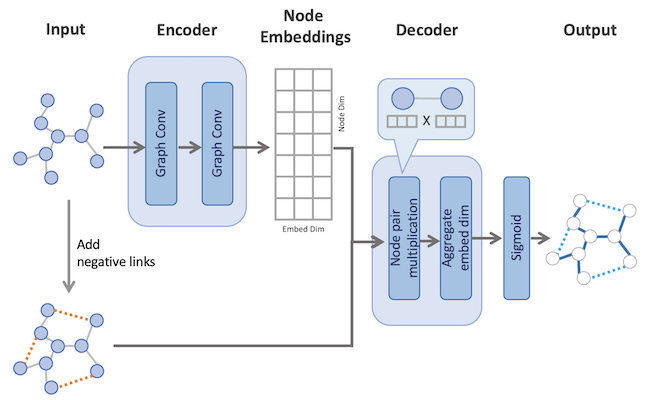

Ссылки на оргинальные тетради: \
1) [Ссылка на первый курс](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial7/GNN_overview.ipynb)


2) [Ссылка на второй курс](https://github.com/tomonori-masui/graph-neural-networks/blob/main/gnn_pyg_implementations.ipynb)

In [ ]:
# @title PyG installation
%%capture

import torch
version = torch.__version__
i = version.find('+')
version = version[:i-1] + '0' + version[i:]
url = 'https://data.pyg.org/whl/torch-' + version + '.html'

!pip install torch-scatter -f $url
!pip install torch-sparse -f $url
!pip install torch-geometric
!pip install torch-cluster -f $url
!pip install pygod
!pip install --upgrade scipy

In [ ]:
# @title imports for GNNs

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid

import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# @title Загружаем данные
dataset = Planetoid(root='/tmp/Cora', name='Cora')
graph = dataset[0]


Processing...
Done!


In [ ]:
# @title Модель для предсказания ребра

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        )  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [ ]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


def train_link_predictor(
    model, train_data, val_data, optimizer, criterion, n_epochs=100
):
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        # sampling training negatives for every training epoch
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(model, val_data)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

    return model


@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [ ]:
split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)
train_data, val_data, test_data = split(graph)
print('TRAIN DATA:', train_data)
print('\nVAL_DATA:', val_data)
print('\nTEST_DATA:', test_data)

TRAIN DATA: Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[4488], edge_label_index=[2, 4488])

VAL_DATA: Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[526], edge_label_index=[2, 526])

TEST_DATA: Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])


In [ ]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
model = train_link_predictor(model, train_data, val_data, optimizer, criterion)


Epoch: 010, Train Loss: 0.681, Val AUC: 0.742
Epoch: 020, Train Loss: 0.633, Val AUC: 0.813
Epoch: 030, Train Loss: 0.541, Val AUC: 0.843
Epoch: 040, Train Loss: 0.501, Val AUC: 0.867
Epoch: 050, Train Loss: 0.474, Val AUC: 0.877
Epoch: 060, Train Loss: 0.452, Val AUC: 0.890
Epoch: 070, Train Loss: 0.443, Val AUC: 0.895
Epoch: 080, Train Loss: 0.442, Val AUC: 0.905
Epoch: 090, Train Loss: 0.430, Val AUC: 0.906
Epoch: 100, Train Loss: 0.417, Val AUC: 0.898


In [ ]:
test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")

Test: 0.904
